# Assignment 8: Robust linear model and Crossvalidation 
This assignment introduces Robust linear regression and Crossvalidation

* Task 1 is designed to deepen your understanding of Model Estimation 7 by using a different loss (robust) function
* Task 2 then introduces you to Polynomial (nonlinear) regression models 
* Task 3 then gets at the core concept of model complexity and overfitting 



In [3]:
## Preliminaries
import matplotlib.pyplot as plt 
import scipy.optimize as so
import pandas as pd 
import numpy as np

## Task 1: Robust regression ( / 20 pts)
### Question 1 ( / 13 pts)
Start with the function code that you wrote in homework 7. Modify the function simpleRegLossRSS to calculate the summed absolute deviation of the prediction from the data (instead of the residual sum-of-squares). Call this new function simpleRegLossSAD. Modify your simpleRegFit function (Task 3, Question 4) from Homework 7 to take a flexible loss function as a 3rd input argument. 

Now call the function with your new loss function to calculate a regression line of tailL (y) against age (x) in the possum data set (see HW7). Your function simpleRegFit should provide a plot of the fit. 

Report the R2 of your fit. 

      fun: 74.0370274395174
 hess_inv: array([[ 0.38092146, -0.07332728],
       [-0.07332728,  0.0146772 ]])
      jac: array([-0.,  2.])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 100
      nit: 7
     njev: 88
   status: 2
  success: False
        x: array([34.39445884,  0.36851372])
427.77680496973517
R2 =  0.1434203566181308


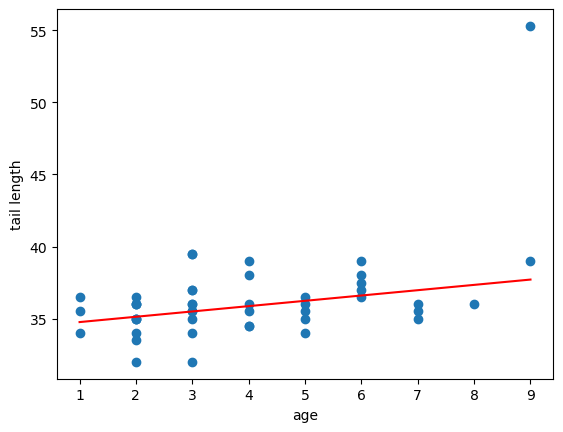

In [18]:
# import dataset
df = pd.read_csv("possum.csv")

# prediction function (doesn't change)
def simpleRegPredict(b,x):
    yp = b[0] + b[1]*x
    return yp 

# RSS loss function
def simpleRegLossRSS(b, x, y):
    predY = simpleRegPredict(b, x)
    res = y - predY
    rss = sum(res**2)
    deriv = np.zeros(2)
    deriv[0] = -2*sum(res)
    deriv[1] = -2*sum(res*x)
    return (rss, deriv)

# SAD loss function
def simpleRegLossSAD(b, x, y):
    predY = simpleRegPredict(b, x)
    res = y - predY
    sad = sum(np.abs(res))     # loss
    derivs = np.zeros(2)
    derivs[0] = -1*sum(np.sign(res))
    derivs[1] = -1*sum(np.sign(res)*x)
    return (sad, derivs.squeeze())

# plotting function
def plotPrediction(b, x, y, predfcn):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x, y)
    xp = np.linspace(min(x), max(x)) 
    yp = predfcn(b, xp)
    ax.plot(xp, yp, 'r')

# function to find the best fit
def simpleRegFit(x, y, fcn = simpleRegLossRSS):
    b0 = [np.mean(y), 0]
    RESULT = so.minimize(fcn, b0, args = (x, y), jac = True)
    print(RESULT)
    b_SAD = RESULT.x    # Results
    plotPrediction(b_SAD, x, y, predfcn = simpleRegPredict)
    
    # calculate residuals
    # res = y - np.mean(y)
    
    # calculate RSS and TSS
    RSS, grad = simpleRegLossRSS(b_SAD, x, y)   # want to use RSS loss fcn
    TSS = sum((y - np.mean(y))**2)  # = sum(res**2)
    print(RSS)

    # calculate R-squared
    R2 = 1 - RSS/TSS 
    return (R2, b_SAD)

# define x and y
x = df["age"]
y = df["tailL"]

# call function
R2, b = simpleRegFit(x, y, fcn = simpleRegLossSAD)

# plot labels
plt.xlabel("age")
plt.ylabel("tail length")

print("R2 = ", R2)

R-squared value is 0.842.

## Question 1.2 (/7pts)
Now use your new function, but this time change the Loss function back to the residual sum of squares (RSS) Loss function from week 7. 
You should now replicate exactly the results you got for HW7, task 3, question 5. 

*Written answer: Compare the two fits you obtain with the absolute error and squared error loss function. How do they compare? Compare the $R^2$ values for both fits. Which one is lower? Why?*

      fun: 388.10162450066576
 hess_inv: array([[ 0.05082113, -0.01009765],
       [-0.01009765,  0.00255215]])
      jac: array([2.41584530e-13, 7.95807864e-13])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([33.35046605,  0.75372836])
388.10162450066576
R2 =  0.22286587947604075


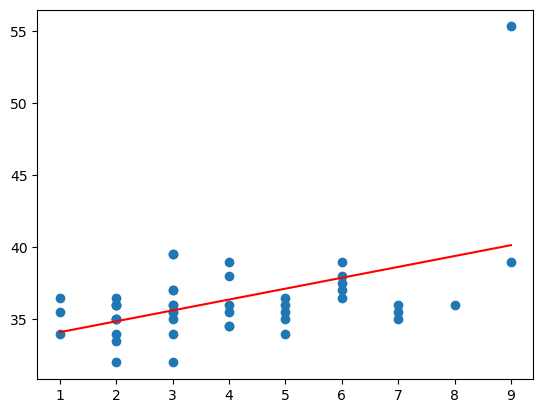

In [19]:
RSS_R2, RSS_b = simpleRegFit(x, y, fcn = simpleRegLossRSS)
print("R2 = ", RSS_R2)

The R-squared from the squared error loss function is 0.223, and is lower than the R-squared from the absolute error loss function of 0.842. The absolute error loss function yields a higher R-squared value, indicating better fit, because it is more robust to the influence of outliers since it is based on median regression. Squared error is not robust as it is based on mean regression, and is susceptible to influence from outliers, giving it worser fit.

## Task 2: Nonlinear (polynomial) regression ( / 40 pts)
For this task, we will use a new data set (fertilizer.csv), which comes from an agricultural study. Each plot of the field (a 10m-by-10m square) was given a randomly determined concentration of fertilizer (in ml/week/m2). The harvest yield for grain in kg/patch was recorded. 
The data has two fields 
- fertCon: Concentration of fertilizer
- harvest: Yield of the harvest in kg


### Question 1 ( / 5 pts)
Load the data set and make a scatter plot of fertilizer concentration on the x-axis and harvest yield on the y-axis. How would you describe the relationship? 

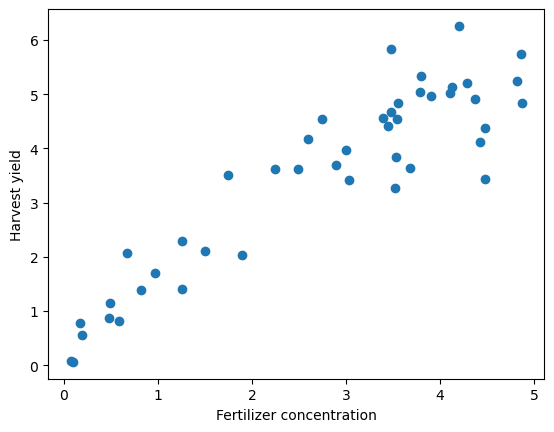

In [21]:
# load dataset
D = pd.read_csv("fertilizer.csv")

# scatterplot of fertilizer concentration vs harvest yield
plt.scatter(D["fertCon"], D["harvest"])     # plt.scatter(D[x-axis], D[y-axis])
plt.xlabel("Fertilizer concentration")
plt.ylabel("Harvest yield")
plt.show()

The relationship appears to be a strong, positive, and linear.

### Question 2 ( / 12 pts)
Write a function called polyRegPredict(b,x) which returns the prediction of a polynomial regression model on x. The length of b should indicate the order of the model. If b has length 1, the model should be of order 0 (constant). If b has length 2, it should be a linear regression model, if b has length 3, it should be quadratic model (order 2). 

Call your function with x=np.linspace(-5,5,10) and b=[-10,-4,1]. Plot the result as a scatter plot.

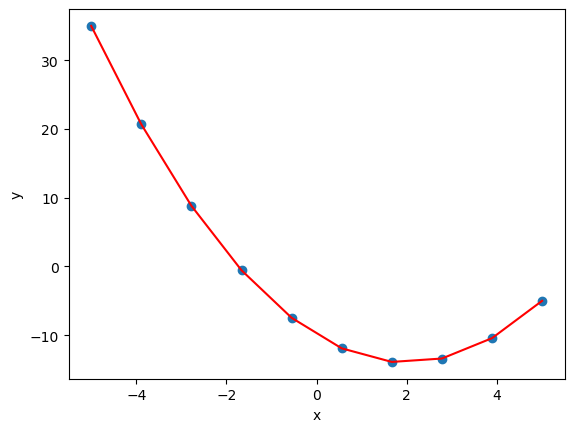

In [24]:
def polyRegPredict(b, x):
    yp = np.zeros(x.shape)
    for i in np.arange(len(b)):
        yp = yp + (b[i]*(x**i))
    return yp

# variables
b = [-10, -4, 1]
xp = np.linspace(-5, 5, 10)

yp = polyRegPredict(b, xp)

# plot
plt.scatter(xp, yp)
plt.plot(xp, yp, color = "red")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Figure 3. Scatter plot of y vs x

### Question 3 ( / 18 pts)
Modify you function simpleRegLossRSS from HW7 to become function polyRegLossRSS, which calculates the residual sum of squares and the derivatives for the polyinomial regression. Also change your function plotPrediction to use polyRegPredict. Then modify your simpleRegFit function to become polyRegFit(x,y,order), which takes the order of the polynomial fit as a third input argument. Call the function for a quadratic fit the harvest yield (y) as a function of fertilizer concentration (x).

Report the $R^2$ for the fit. 

R2 is: 0.875


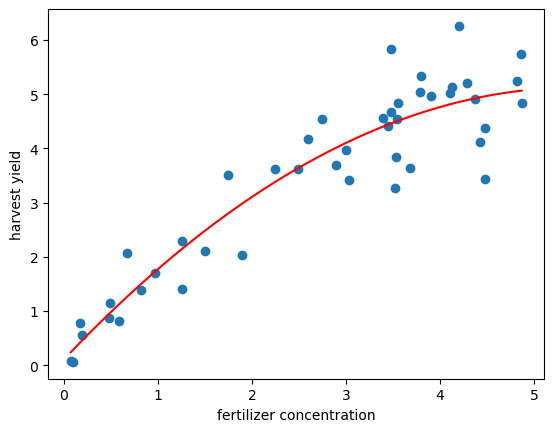

In [26]:
def polyRegLossRSS(b, x, y):
    predY = polyRegPredict(b, x)
    res = y - predY
    rss = sum(res**2)
    grad = np.zeros(len(b))
    for i in range(len(b)):
        grad[i] = -2*np.sum((x**i)*res)
    return (rss, grad)


def polyRegFit(x, y, order = 1, linestyle ='r-', fig = True):
    b0 = np.zeros((order + 1,))
    RES = so.minimize(polyRegLossRSS, b0, args = (x, y), jac = True, options = {'gtol':1e-2})
    b = RES.x # Results
    # b=polyRegressionFit(x,y,order) 
    if (fig):
        plotPrediction(b, x, y, polyRegPredict) 
    res = y - np.mean(y)
    TSS = sum(res**2)
    RSS, grad = polyRegLossRSS(b, x, y)
    R2 = 1 - RSS/TSS 
#     print("R2 is {0:3.2f}".format(R2))
    return (R2, b)

# variables
x = D["fertCon"]
y = D["harvest"]

# call function
R2, b = polyRegFit(x, y, order = 2)
plt.xlabel('fertilizer concentration')
plt.ylabel('harvest yield')
print(f'R2 is: {R2:.3f}')

Figure 4. Figure shows the scatter plot harvest yield vs fertilizer concentration. A quadratic polynomial fit is also shown on top of the scatter plot.

### Question 4 ( / 5 pts)
Call you polyRegression function to produce a polynomial fit of order 8. 

What is the $R^2$? 

R2 is: 0.901


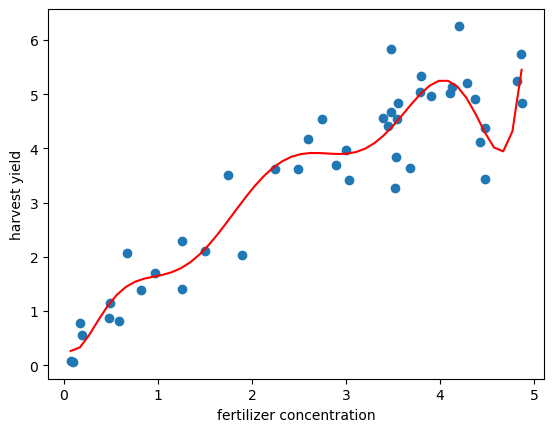

In [27]:
R2,b = polyRegFit(x, y, 8)
plt.xlabel('fertilizer concentration')
plt.ylabel('harvest yield')
print(f'R2 is: {R2:.3f}')

Figure 5. Figure shows the scatter plot of harvest yield vs. fertilizer concentration. A 8th order polynomial is also plotted on top the scatter plot.

## Task 3: Cross-validation of models ( / 40 pts)
### Question 1 ( / 20 pts)
Write a function leaveOneOutCV, which takes as inputs x and y, a function to be called for the fit, optional input arguments for the fit, and a function to be called for prediction. The function should then perform leave-on-out crossvalidation and calculate the cross-validated R2. It should then fit the model to all data and calculate the fitted R2. 

*Hint:The sketch of the function can be found in the lecture.*

Call the function to get a cross-validated $R^2$ for a polynomial fit of order 8. How much lower is the crossvalidated $R^2$ than the fitted $R^2$? 

R2cv is: 0.851. R2 is: 0.901. 


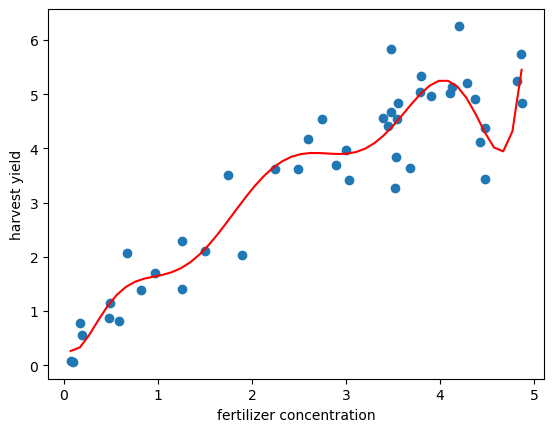

In [29]:
def leaveOneOutCV(x,y,fitfcn=polyRegFit,args=(),predictfcn=polyRegPredict):
    N = len(x) #Number of observations 
    yp = np.zeros(N)
    ind = np.arange(N)
    for i in range(N):
        r, b = fitfcn(x[ind != i], y[ind != i], args, fig = False)
        yp[i] = predictfcn(b, x[i])
    TSS  = sum((y - y.mean())**2)
    RSScv = sum((y - yp)**2)
    R2cv = 1 - RSScv/TSS

    # Get the model fit 
    r, b = fitfcn(x, y, args)
    yf = predictfcn(b, x)
    RSS = sum((y - yf)**2)
    R2 = 1 - RSS/TSS
    return R2cv,R2 

R2cv, R2 = leaveOneOutCV(x, y, args = (8))
plt.xlabel('fertilizer concentration')
plt.ylabel('harvest yield')
print(f'R2cv is: {R2cv:.3f}. R2 is: {R2:.3f}. ')

Figure 6. Figure shows the scatter plot of harvest yield vs. fertilizer concentration. A 8th order polynomial is also plotted on top the scatter plot.

The crossvalidated R2 indicates that the model can predict 0.05 (5%) of the variance less than it can fit.  

### Question 2 ( / 20 pts)
Run a loop from model order 0 (constant) to model order 8. For each polynomial model order, call you function leaveOneOutCV to get the crossvalidated R2 and the normal R2 for each model order. Make a plot where you show the line for the crossvalidated R2 and R2 as a function of model order. When is the best crossvalidated R2 reached? When does the model start overfitting? Which model would you use to make a prediction for an unobserved data point? 

0
1
2
3
4
5
6
7
8


Text(0, 0.5, 'Coefficient of Determination')

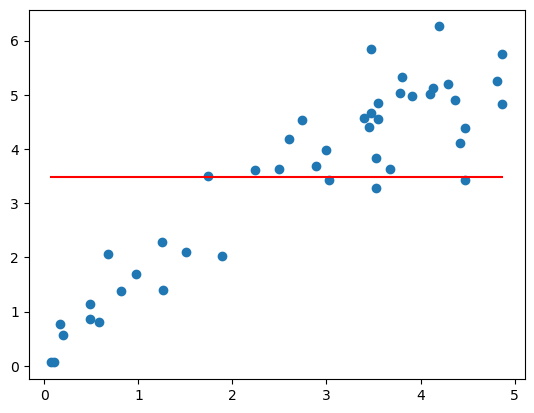

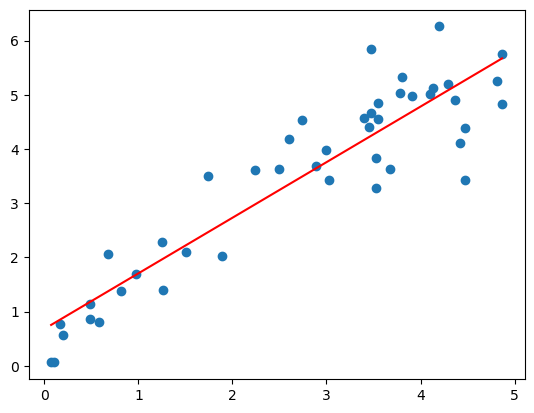

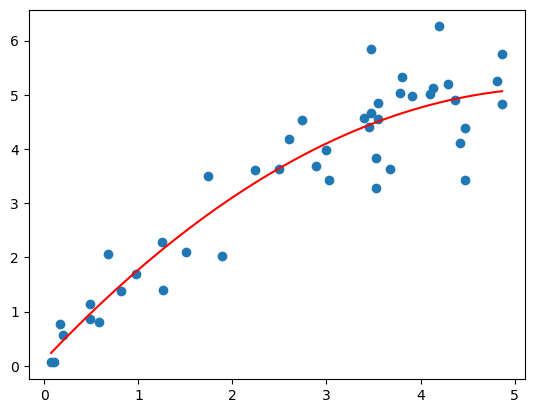

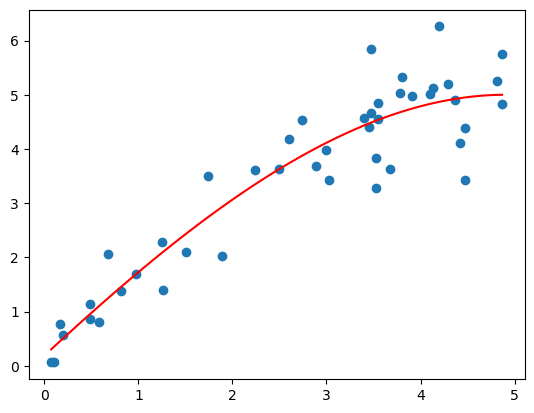

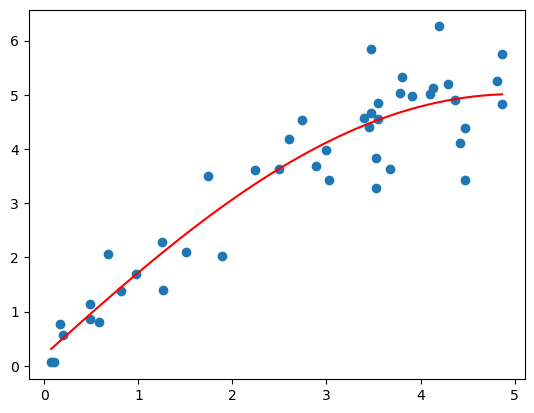

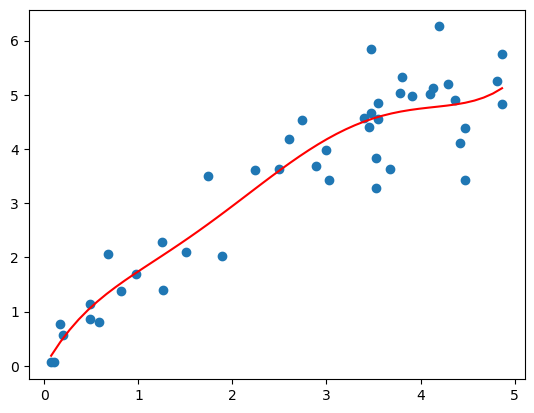

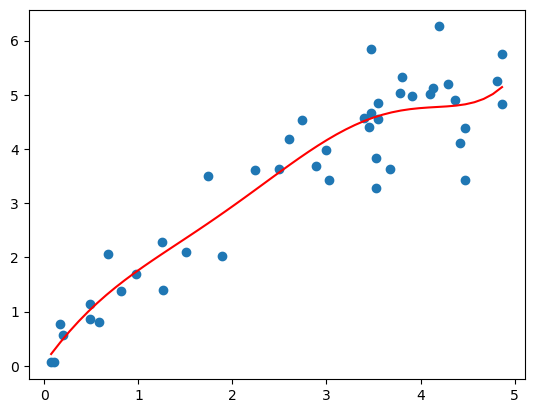

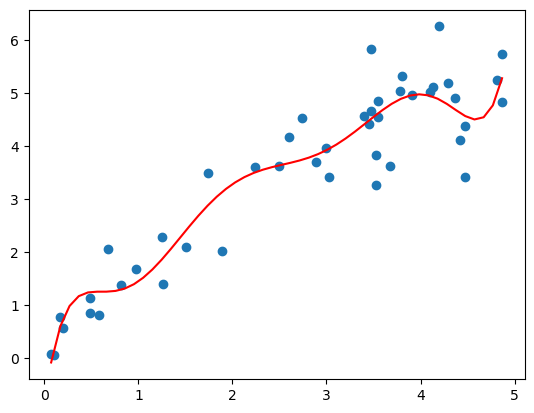

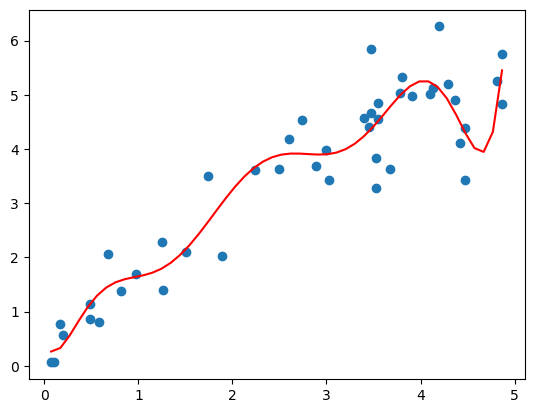

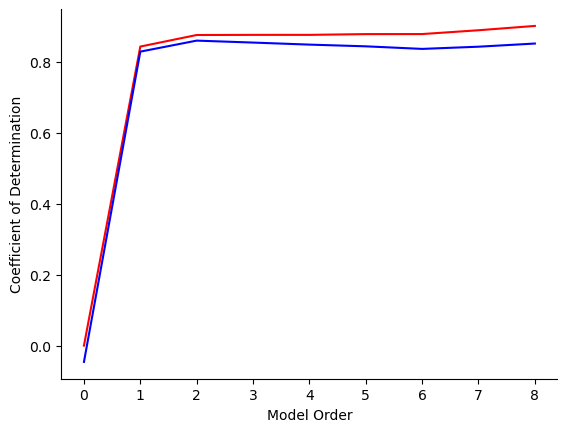

In [30]:
numMod = 9  # Including 0, we need 8 models 
R2 = np.zeros(numMod)
R2cv = np.zeros(numMod)
    
for i in range(numMod):
    R2cv[i], R2[i] = leaveOneOutCV(x, y, args = (i))
    print(i)

    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
model = np.arange(0, numMod)
ax.plot(model, R2, 'r')
ax.plot(model, R2cv, 'b')    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Model Order')
plt.ylabel('Coefficient of Determination')

The best cross-validated R2 is reached at a quadratic model (model order 2). Afterwards, the R2cv starts declining. The difference between R2 and cvR2 starts becoming bigger, so the model is starting to overfit the data. I would therefore choose to use the quadratic model to make predictions about new data. 